In this practical session, you will implement different strategies to build a recommender system.

# Dataset



We will use The Movie Dataset, available on Kaggle.  
It contains metadata for all 45,000 movies listed in the [Full MovieLens Dataset](https://grouplens.org/datasets/movielens/). The dataset consists of movies released on or before July 2017. Data points include cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages.

This dataset also has files containing 26 million ratings from 270,000 users for all 45,000 movies. Ratings are on a scale of 1-5 and have been obtained from the official GroupLens website.  
You will need [Kaggle](https://www.kaggle.com/) account to download the data.  You should already have one since the DEFI IA is hosted on Kaggle this year. If you don't, it is time to create your account (and to start participating to the DEFI ;-) )  
Once you are logged into Kaggle, go to your account and scroll down to the API section to generate a new token.  
![](https://drive.google.com/uc?export=view&id=1YcSTHD_FGrwDKaaLk6T9Gsdte8TKuPCt)  
We will now install the kaggle library to download the dataset directly from the notebook.



In [1]:
!pip install kaggle

Run the next cell to upload your token.

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


We will start by working with the metadata dataset.
It contains information about the movies like their title, description, genres, or even their average IMDB ratings.

In [ ]:
!kaggle datasets download "rounakbanik/the-movies-dataset" -f movies_metadata.csv
!kaggle datasets download "rounakbanik/the-movies-dataset" -f ratings.csv
!unzip movies_metadata.csv.zip
!unzip ratings.csv.zip

Use pandas to explore the *movies_metadata.csv* dataset.

In [4]:
import pandas as pd
metadata = pd.read_csv('movies_metadata.csv')
metadata.dropna(subset=['title'], inplace=True)
metadata['id'] = pd.to_numeric(metadata['id'])
metadata['genres'] = metadata['genres'].apply(lambda x: ' '.join([i['name'] for i in eval(x)]))
metadata.head(5)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,Animation Comedy Family,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,Adventure Fantasy Family,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,Romance Comedy,NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,Comedy Drama Romance,NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,Comedy,NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


Create a new column called _year_ and use seaborn to plot the number of movies per year.

In [5]:
metadata['year'] = pd.DatetimeIndex(metadata['release_date']).year

Text(0.5, 1.0, 'Number of movies by year')

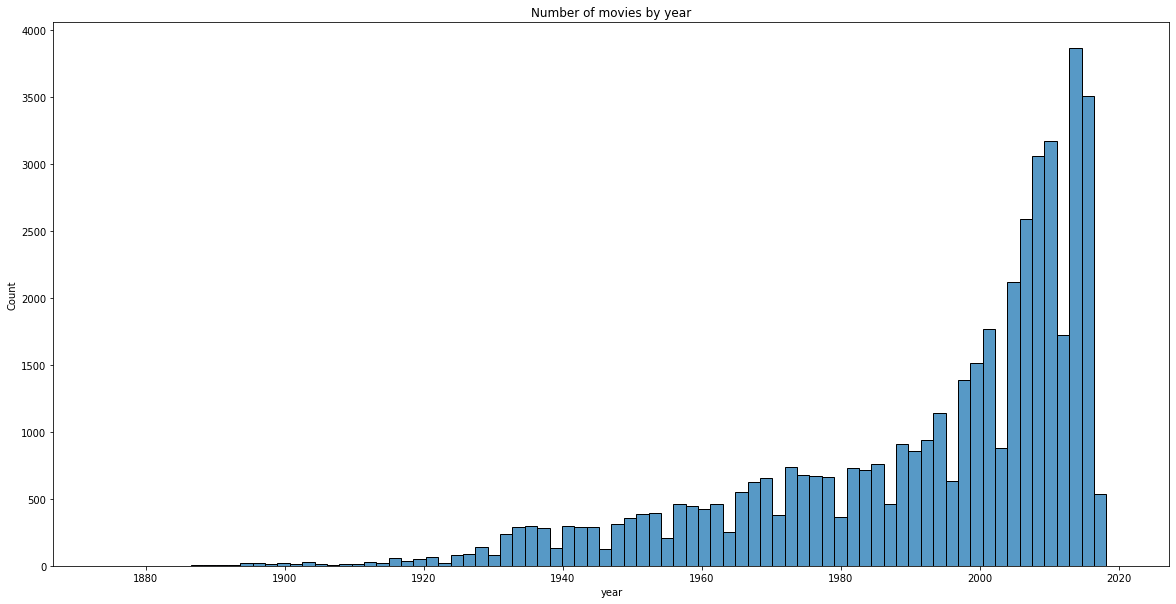

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

metadata['year'] = pd.DatetimeIndex(metadata['release_date']).year

plt.figure(figsize=(20,10))
sns.histplot(data=metadata, x="year")
plt.title('Number of movies by year')

# Recommendation by popularity

The metadata dataset contains informations about ratings in the _vote_average_ column.  
A classical baseline, or cold start when you implement a recommender system consists in using popular products.  
## Best movies by average note  
Try to visualize the movies with the best vote average.
Do you know these movies?

In [7]:
metadata.sort_values('vote_average', ascending=False).head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
21642,False,NaN,0,Documentary,NaN,320849,tt0886500,en,Ice Age Columbus: Who Were the First Americans?,Firmly rooted in the latest scientific discove...,0.043244,/mzEy02GOD5i2BNs15ma06vhO3uu.jpg,[],[],2005-01-01,0.0,0.0,[],Released,NaN,Ice Age Columbus: Who Were the First Americans?,False,10.0,1.0,2005.0
15710,False,NaN,0,Documentary,NaN,96451,tt1587373,en,If God Is Willing and da Creek Don't Rise,"In 2006, director Spike Lee created an astonis...",0.109599,/d0eQy5xYxZnJsVYhRic8aIX0lA2.jpg,"[{'name': '40 Acres & A Mule Filmworks', 'id':...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-08-23,0.0,255.0,[],Released,NaN,If God Is Willing and da Creek Don't Rise,False,10.0,1.0,2010.0
22396,False,NaN,0,Documentary,NaN,72123,tt1341746,en,Meat the Truth,Meat the Truth is a high-profile documentary w...,0.09108,/ANTsGDien6MwXKndxObZQIoz3c.jpg,[],[],2008-10-03,0.0,74.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Meat the Truth,False,10.0,1.0,2008.0
22395,False,NaN,0,Documentary,http://www.marvinhamlischmovie.com/,230864,tt3011874,en,Marvin Hamlisch: What He Did For Love,When Marvin Hamlisch passed away in August 201...,0.371755,/yJca3h32YP72I31bvqdXubYSuxV.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2013-10-12,0.0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Marvin Hamlisch: What He Did For Love,False,10.0,1.0,2013.0
35343,False,NaN,300000,Comedy Documentary Music TV Movie,NaN,140595,tt0308213,en,Elaine Stritch: At Liberty,Judy at the Palace. Sinatra at Carnegie Hall. ...,0.089067,/k4HGhaRWfEl7ZWXuh3Mq2EEG9ER.jpg,"[{'name': 'Pennebaker Hegedus Films, Inc.', 'i...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2002-01-01,0.0,140.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Legendary performances come along so rarely.,Elaine Stritch: At Liberty,False,10.0,1.0,2002.0


You may have guessed that the average score is only reliable when it is averaged on a sufficient number of votes.  
Use seaborn ```histplot``` method to plot the histograme of the number of votes.
For better readability you may first do this plot for the movies with less than 100 votes and then do another ones for the remaining ones.

Text(0.5, 1.0, 'Vote count')

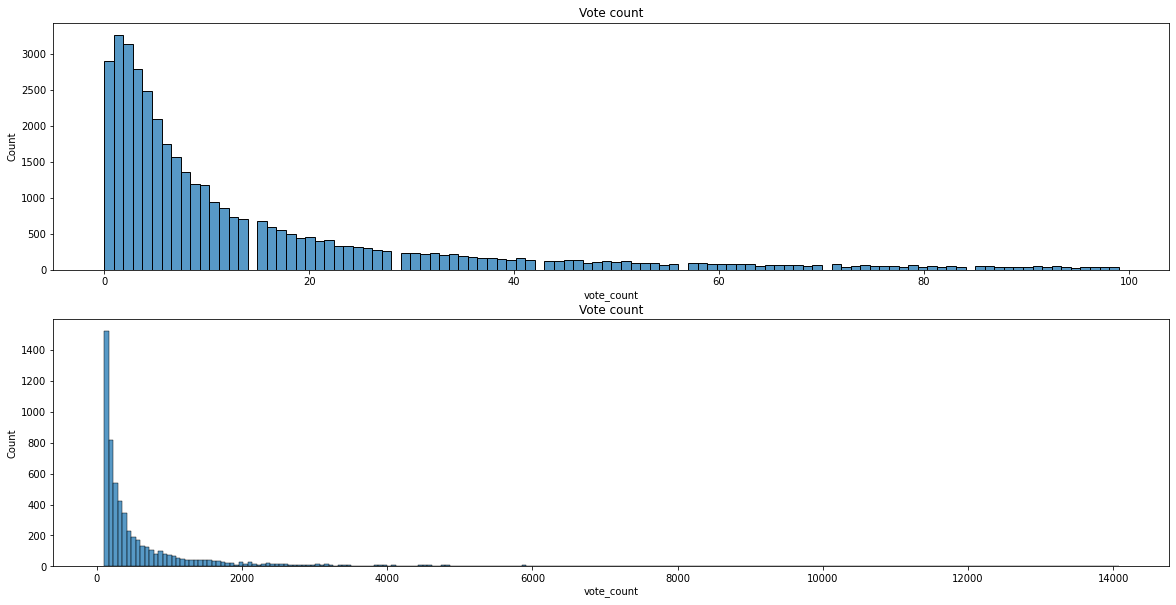

In [8]:
metadata['year'] = pd.DatetimeIndex(metadata['release_date']).year
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(data=metadata[metadata['vote_count']< 100], x="vote_count")
plt.title('Vote count')
plt.subplot(2,1,2)
sns.histplot(data=metadata[metadata['vote_count']> 100], x="vote_count")
plt.title('Vote count')

Try to visualize the best movies according to the average vote for movies that have at least 1000 votes.
You should now know some of these movies.


In [9]:
best_movies = metadata[metadata['vote_count'] > 1000].sort_values('vote_average', ascending=False)
best_movies[['title', 'vote_average']].head(15)

,title,vote_average
314,The Shawshank Redemption,8.5
40251,Your Name.,8.5
834,The Godfather,8.5
1152,One Flew Over the Cuckoo's Nest,8.3
1176,Psycho,8.3
1178,The Godfather: Part II,8.3
1184,Once Upon a Time in America,8.3
522,Schindler's List,8.3
5481,Spirited Away,8.3
292,Pulp Fiction,8.3


## Best movies by IMDb score  
IMDb (an acronym for Internet Movie Database) is an online database of information related to films, television programs, home videos, video games, and streaming content online.  
It might be considered as one of the most exhaustive databases on movies.  
In addition, IMDb maintains a ranking of movies according to people's votes. To do so, it computes a score based on the average rating and the number of votes. 
The formula they are using is described [here](https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV#)  
![](https://drive.google.com/uc?export=view&id=12J_uJ86eOimr8Y0LHTGSMmUgkBnZu9cO)   
Use this formula to compute the IMDb score for all movies and visualize the ones with the best scores. (You may use a smaller value for m, 500 for example)


In [10]:
m = 500
c = metadata.vote_average.mean()

def imdb_score(x):
    v = x['vote_count']
    r= x['vote_average']
    return (v/(v+m) * r) + (m/(m+v) * c)

metadata['imdb_score'] = metadata.apply(imdb_score, axis=1)
best_movies = metadata.sort_values('imdb_score', ascending=False)
best_movies[['title', 'imdb_score']].head(15)

,title,imdb_score
314,The Shawshank Redemption,8.337334
834,The Godfather,8.279139
12481,The Dark Knight,8.194988
2843,Fight Club,8.168255
292,Pulp Fiction,8.153774
351,Forrest Gump,8.050712
522,Schindler's List,8.028344
23673,Whiplash,8.025001
15480,Inception,8.014861
1154,The Empire Strikes Back,8.001339


What were the best movies in your birth year?

In [11]:
best_movies = metadata[metadata.year == 1987].sort_values('imdb_score', ascending=False)
best_movies[['title', 'imdb_score']].head(15)

,title,imdb_score
1179,Full Metal Jacket,7.531374
1155,The Princess Bride,7.108971
2085,The Untouchables,7.084981
3406,Predator,6.980146
1216,Evil Dead II,6.753257
2869,RoboCop,6.728437
1056,Dirty Dancing,6.704010
1891,Lethal Weapon,6.629943
3328,"Good Morning, Vietnam",6.460193
3977,Empire of the Sun,6.451467


The following code will create a data frame containing one-hot encoding of the movie's genre.  
Use it to recommend the best movies according to the genre and the IMDB score (for example the best Horror movies)

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

metadata['genres_list'] = metadata['genres'].apply(lambda s: s.split(" "))
mlb = MultiLabelBinarizer()
genre_df = pd.DataFrame(mlb.fit_transform(metadata['genres_list'].fillna('[]')),columns=mlb.classes_, index=metadata.index)
genre_df.head()

,,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Fiction,Foreign,History,Horror,Movie,Music,Mystery,Romance,Science,TV,Thriller,War,Western
0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
best_movies = metadata[genre_df['Comedy'] == 1].sort_values('imdb_score', ascending=False)
best_movies[['title', 'imdb_score']].head(15)

,title,imdb_score
351,Forrest Gump,8.050712
18465,The Intouchables,7.981574
2211,Life Is Beautiful,7.976347
1225,Back to the Future,7.823283
22841,The Grand Budapest Hotel,7.768488
22131,The Wolf of Wall Street,7.743025
30315,Inside Out,7.742352
40882,La La Land,7.682479
13724,Up,7.655472
24455,Big Hero 6,7.639314


# Content based recommender systems

### Item description
Another way to create a recommender system is to base the recommendations on the content.
It is an exciting way to start a recommender system when you do not have many user interactions or new items to recommend.  
In many cases, the text description is a good starting point.
Use what you learned from the first practical section on text data to compute a TF-IDF matrix with the descriptions of the movies (since colab has limited RAM, use a max of 4000 features. We will also work on a subset of the dataset using only the film that were displayed after 2000). 

In [14]:
metadata['overview'] = metadata['overview'].fillna('')
subset = metadata[metadata['release_date'] > "2000"].reset_index()
subset['overview'].head()

0    Two Sicilian friends, Nunzio and Pino, share t...
1    An atmospheric coming-of-age story featuring a...
2    The town of Derry has a secret, but no one tol...
3    As her surroundings are invaded by outsiders, ...
4    Using personal stories, this powerful document...
Name: overview, dtype: object

In [15]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('wordnet')
nltk.download('stopwords')
# Download stopwords list
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

# Interface lemma tokenizer from nltk with sklearn
class LemmaTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in self.ignore_tokens]

# Lemmatize the stop words
tokenizer=LemmaTokenizer()
token_stop = tokenizer(' '.join(stop_words))

# Create TF-idf model
tfidf = TfidfVectorizer(stop_words=token_stop, tokenizer=tokenizer, max_features=4000)

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(subset['overview'])



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Now that you have a representation computed for each movie, you can calculate distances or similarities for movie pairs.
Compute the cosine similarity matrix of your TF-IDF Matrix.  
You may use scikit-learn 's [cosine_distances](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html) function.

In [16]:
from sklearn.metrics.pairwise import cosine_distances
cosine_sim = cosine_distances(tfidf_matrix, tfidf_matrix)

We will create a list containig the movies with the correct indexes to help us recommended movies.

In [18]:
titles = subset['title']
indices = pd.Series(subset.index, index=subset['title'])
titles[370:390]

370                  Michael Jordan to the Max
371                             Haunted Castle
372    All Access: Front Row. Backstage. Live!
373                       Camille Claudel 1915
374                          Jurassic Park III
375                      America's Sweethearts
376                                    Brother
377                                Ghost World
378                  Hedwig and the Angry Inch
379                         Planet of the Apes
380                           Bread and Tulips
381                               Greenfingers
382                                    Jackpot
383                          The Monkey's Mask
384                    Wet Hot American Summer
385                               Original Sin
386                       The Princess Diaries
387                                Rush Hour 2
388                             Thomas in Love
389                             American Pie 2
Name: title, dtype: object

Use the following function with your similarity matrix to recommend movies from another movie title.

In [19]:
def get_reco(title, sim_matrix):
  idx = indices[title]
  print(f'original: {title}')
  recos = sim_matrix[idx].argsort()[1:6]
  recos = titles.iloc[recos]

  print(recos)

title = 'The Dark Knight Rises'#'Rush Hour 2'
get_reco(title, cosine_sim)

original: The Dark Knight Rises
3760                                       The Dark Knight
20963    LEGO DC Comics Super Heroes: Batman: Be-Leaguered
3225                                             Slow Burn
9084     Batman Unmasked: The Psychology of the Dark Kn...
13832                                              Accused
Name: title, dtype: object


Delete the similarity matrix to free some meomry in the Colab instance.



In [20]:
del(cosine_sim)

### Item attributes
Sometimes your catalog is also filled with additional information about the items.  
These pieces of information are usually hand filled and may contain insightful features for a content-based recommender system.  
In our case we will download an associated dataset containing informations about the movie casting and the production crew and an other dataset containing keywords associated to the movies.

In [22]:
!kaggle datasets download "rounakbanik/the-movies-dataset" -f credits.csv
!unzip credits.csv.zip

 95% 41.0M/43.1M [00:00<00:00, 51.0MB/s]
100% 43.1M/43.1M [00:00<00:00, 49.2MB/s]
Archive:  credits.csv.zip
  inflating: credits.csv             


In [23]:
credits = pd.read_csv('credits.csv')
credits['cast'] = credits['cast'].apply(lambda x: ' '.join([i['name'].replace(' ', '') for i in eval(x)]))
credits['crew'] = credits['crew'].apply(lambda x: ' '.join([i['name'].replace(' ', '') for i in eval(x)]))
credits.head()

,cast,crew,id
0,TomHanks TimAllen DonRickles JimVarney Wallace...,JohnLasseter JossWhedon AndrewStanton JoelCohe...,862
1,RobinWilliams JonathanHyde KirstenDunst Bradle...,LarryJ.Franco JonathanHensleigh JamesHorner Jo...,8844
2,WalterMatthau JackLemmon Ann-Margret SophiaLor...,HowardDeutch MarkStevenJohnson MarkStevenJohns...,15602
3,WhitneyHouston AngelaBassett LorettaDevine Lel...,ForestWhitaker RonaldBass RonaldBass EzraSwerd...,31357
4,SteveMartin DianeKeaton MartinShort KimberlyWi...,AlanSilvestri ElliotDavis NancyMeyers NancyMey...,11862


In [24]:
!kaggle datasets download "rounakbanik/the-movies-dataset" -f keywords.csv
!unzip keywords.csv.zip

  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 45.8MB/s]
Archive:  keywords.csv.zip
  inflating: keywords.csv            


In [25]:
keywords = pd.read_csv('keywords.csv')
keywords['keywords'] = keywords['keywords'].apply(lambda x: ' '.join([i['name'] for i in eval(x)]))
keywords.head()

,id,keywords
0,862,jealousy toy boy friendship friends rivalry bo...
1,8844,board game disappearance based on children's b...
2,15602,fishing best friend duringcreditsstinger old men
3,31357,based on novel interracial relationship single...
4,11862,baby midlife crisis confidence aging daughter ...


We will now create another dataframe containing all the movies attributes.

In [26]:
attributes_df = pd.merge(keywords, credits, on='id')
attributes_df = pd.merge(attributes_df, metadata, on='id')
attributes_df = attributes_df.sort_values('vote_count', ascending=False).drop_duplicates(subset='id').reset_index()
# We will aslo use a subset to avoid Out of Memory issues
attributes_df = attributes_df[attributes_df['release_date'] > "2000"].reset_index()
attributes_df[['title', 'genres', 'cast', 'crew', 'keywords']].head()

,title,genres,cast,crew,keywords
0,Inception,Action Thriller Science Fiction Mystery Adventure,LeonardoDiCaprio JosephGordon-Levitt EllenPage...,HansZimmer ChristopherNolan ChristopherNolan C...,loss of lover dream kidnapping sleep subconsci...
1,The Dark Knight,Drama Action Crime Thriller,ChristianBale MichaelCaine HeathLedger AaronEc...,LucindaSyson HansZimmer CharlesRoven Christoph...,dc comics crime fighter secret identity scarec...
2,Avatar,Action Adventure Fantasy Science Fiction,SamWorthington ZoeSaldana SigourneyWeaver Step...,StephenE.Rivkin RickCarter ChristopherBoyes Ch...,culture clash future space war space colony so...
3,The Avengers,Science Fiction Action Adventure,RobertDowneyJr. ChrisEvans MarkRuffalo ChrisHe...,AlanSilvestri ChristopherBoyes ChristopherBoye...,new york shield marvel comic superhero based o...
4,Deadpool,Action Adventure Comedy,RyanReynolds MorenaBaccarin EdSkrein T.J.Mille...,RobertAlonzo TimMiller RhettReese PaulWernick ...,anti hero mercenary marvel comic superhero bas...


Create a new columns called *attributes* where you will concatenate the genre, the cast, the crew and the keywords.

In [27]:
attributes_df['attributes'] = attributes_df['genres']+" "+attributes_df['cast']+" "+attributes_df['crew']+" "+attributes_df['keywords']

Now repeat the previous feature extraction by TF-IDF on this column and compute a new similarity matrix.

In [28]:
tfidf = TfidfVectorizer(stop_words=token_stop, tokenizer=tokenizer, max_features=4000)
tfidf_matrix = tfidf.fit_transform(attributes_df['attributes'])
cosine_sim = cosine_distances(tfidf_matrix, tfidf_matrix)

We may need to re-create our tiltle index dataframe.

In [29]:
titles = attributes_df['title']
indices = pd.Series(attributes_df.index, index=attributes_df['title'])
titles[370:390]

370               Lara Croft: Tomb Raider
371                               Taken 3
372                                   Rio
373                       The Book of Eli
374                          Ghostbusters
375                                  Hugo
376           Scott Pilgrim vs. the World
377                       Angels & Demons
378                        Hidden Figures
379    Terminator 3: Rise of the Machines
380                           John Carter
381                        Ocean's Twelve
382                                 Click
383                        50 First Dates
384                              Superbad
385                            Battleship
386                            About Time
387                       American Psycho
388                                  Salt
389                             The Mummy
Name: title, dtype: object

Try your new matrix similarity to recommend movies based on these new attributes.

In [30]:
title = 'Rush Hour 2'#'Inception'
get_reco(title, cosine_sim)

original: Rush Hour 2
4317           Police Story 2013
14189    My Wife Is a Gangster 2
21665        Where's the Dragon?
19240                 Darfur Now
10330         Looking for Jackie
Name: title, dtype: object


Let's free some meomry in the Colab instance.

In [31]:
del(cosine_distances)
del(tfidf_matrix)
del(attributes_df)

### Images

An other type of content may be one or several images of the products. 
It may not necessarily be relevant in the case of movies but let's do it anyway.  
We will now work with images and recommend movies according to their posters.  
We first need to download another dataset.

In [32]:
!kaggle datasets download "ghrzarea/movielens-20m-posters-for-machine-learning"
!unzip movielens-20m-posters-for-machine-learning.zip

Streaming output truncated to the last 5000 lines.
  inflating: mlp-20m/MLP-20M/81566.jpg  
  inflating: mlp-20m/MLP-20M/81568.jpg  
  inflating: mlp-20m/MLP-20M/8157.jpg  
  inflating: mlp-20m/MLP-20M/81574.jpg  
  inflating: mlp-20m/MLP-20M/8158.jpg  
  inflating: mlp-20m/MLP-20M/81583.jpg  
  inflating: mlp-20m/MLP-20M/81585.jpg  
  inflating: mlp-20m/MLP-20M/81587.jpg  
  inflating: mlp-20m/MLP-20M/81589.jpg  
  inflating: mlp-20m/MLP-20M/81591.jpg  
  inflating: mlp-20m/MLP-20M/816.jpg  
  inflating: mlp-20m/MLP-20M/81610.jpg  
  inflating: mlp-20m/MLP-20M/81613.jpg  
  inflating: mlp-20m/MLP-20M/81615.jpg  
  inflating: mlp-20m/MLP-20M/81617.jpg  
  inflating: mlp-20m/MLP-20M/81621.jpg  
  inflating: mlp-20m/MLP-20M/81629.jpg  
  inflating: mlp-20m/MLP-20M/81631.jpg  
  inflating: mlp-20m/MLP-20M/81633.jpg  
  inflating: mlp-20m/MLP-20M/81637.jpg  
  inflating: mlp-20m/MLP-20M/81639.jpg  
  inflating: mlp-20m/MLP-20M/81641.jpg  
  inflating: mlp-20m/MLP-20M/81643.jpg  
  inflatin

The following code will allow us to load the data.

In [33]:
# taken from  andrewjong/pytorch_image_folder_with_file_paths.py (https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d) 

import torch
from torchvision import datasets

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path



We will use a pre-trained network to extract the features from the posters.   
Similar to what we did with the text descriptions, we will compute similarities between the movies according to these features.  

The pre-trained model we will be using was trained with normalized images. Thus, we have to normalize our posters before feeding them to the network.  
The following code will instantiate a data loader with normalized images and provide a function to revert the normalization for visualization purposes.


In [34]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

mean = [ 0.485, 0.456, 0.406 ]
std = [ 0.229, 0.224, 0.225 ]
normalize = transforms.Normalize(mean, std)
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                normalize])
dataset = ImageFolderWithPaths('MLP-20M', transform)    
    
dataloader = DataLoader(dataset, batch_size=128, num_workers=2)

Here are some exemples of posters:

(-0.5, 1809.5, 453.5, -0.5)

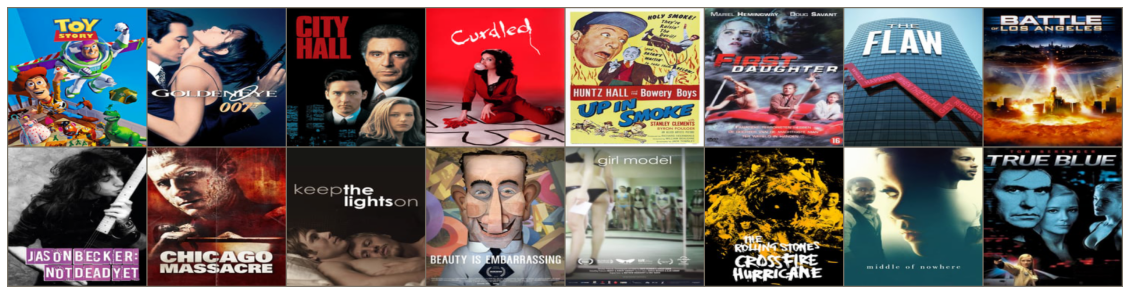

In [35]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
x, _, paths = next(iter(dataloader))
img_grid = make_grid(x[:16])
img_grid = inv_normalize(img_grid)
plt.figure(figsize=(20,15))
plt.imshow(img_grid.permute(1, 2, 0))
plt.axis('off')

Instantiate a pre-trained a mobilenet_v3_small model (documentation [here](https://pytorch.org/vision/stable/models.html))

In [36]:
import torchvision.models as models
mobilenet = models.mobilenet_v3_small(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

Have a look to the model:

In [37]:
mobilenet

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride

We will now crate a subset of this model to extract the features.  
Use a Sequential model to get only the features followed by the avgpool layer of mobilnet and finish with a Flatten layer (```torch.nn.Flatten()```)


In [38]:
model = torch.nn.Sequential(mobilenet.features, mobilenet.avgpool, torch.nn.Flatten()).cuda()

If your model is OK, it should predict 576-dimensional vectors.

In [39]:
import torch
x = torch.zeros(100, 3, 224,224).cuda()
y = model(x)
y.shape

torch.Size([100, 576])

We will now create a dataframe with our extracted features and the path to the poster image.

In [40]:
import pandas as pd
from tqdm.notebook import tqdm

df = pd.DataFrame(columns=["features", "path"])
for x, _, paths in tqdm(dataloader):
  with torch.no_grad():
    y = model(x.cuda())
  tmp = pd.DataFrame({'features': list(y.cpu().numpy()), 'path': list(paths)})
  df = df.append(tmp, ignore_index=True)
df.head()

  0%|          | 0/211 [00:00<?, ?it/s]

,features,path
0,"[0.780161, 0.27348897, 0.3860399, 0.26672244, ...",MLP-20M/MLP-20M/1.jpg
1,"[0.40198368, 1.1575996, 0.5941725, 0.3052399, ...",MLP-20M/MLP-20M/10.jpg
2,"[0.29196498, 0.0006246664, -0.026406085, 0.445...",MLP-20M/MLP-20M/100.jpg
3,"[0.0974551, 0.42420274, 0.6901719, 0.022360368...",MLP-20M/MLP-20M/1000.jpg
4,"[0.3919826, -0.038788572, 0.21787335, 0.398794...",MLP-20M/MLP-20M/100003.jpg


We will now extract all the features into a numpy array that will be used to compute the similarity matrix.

In [41]:
import numpy as np
features = np.vstack(df.features)
features.shape

(26938, 576)

Now compute the cosine similarity between your features.

In [42]:
from sklearn.metrics.pairwise import cosine_distances
cosine_sim = cosine_distances(features, features)
cosine_sim.shape

(26938, 26938)

The ```plot_image``` function  will display a poster according to it's path.  
Fill the ```plot_images``` function to plot a series of posters from a list of paths

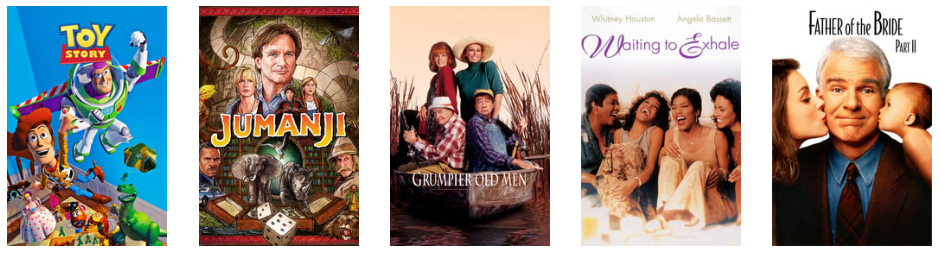

In [43]:
import matplotlib.image as mpimg

def plot_image(path):
  img = mpimg.imread(path)
  plt.imshow(img)
  plt.axis('off')

def plot_images(paths_list):
  plt.figure(figsize=(20,20))
  n = len(paths_list)
  for i, path in enumerate(paths_list):
    plt.subplot(1, n+1, i+1)
    plot_image(path)


plot_images(['MLP-20M/MLP-20M/1.jpg', 'MLP-20M/MLP-20M/2.jpg', 'MLP-20M/MLP-20M/3.jpg', 'MLP-20M/MLP-20M/4.jpg', 'MLP-20M/MLP-20M/5.jpg'])

Fill the following code to implement a function that will plot the top 5 recommendations for a movie according to its index.

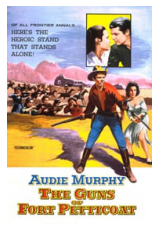

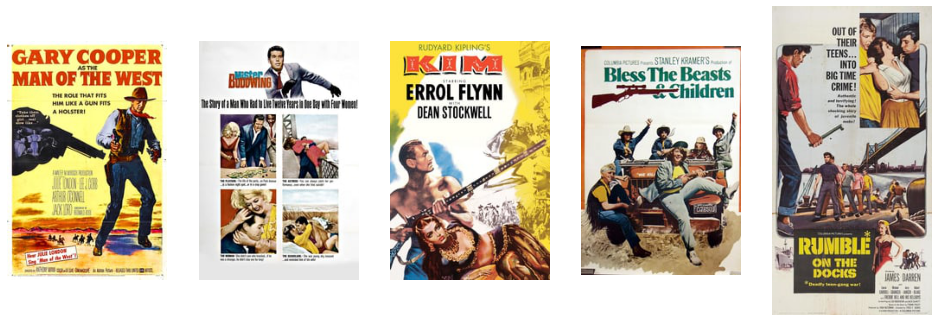

In [44]:
def plot_reco(idx, sim_matrix):
  img = plot_image(df['path'][idx])
  recos = sim_matrix[idx].argsort()[1:6]
  reco_posters = df.iloc[recos]['path'].tolist()
  plot_images(reco_posters)

idx = 16 #10 #200
plot_reco(idx, cosine_sim)

Try with different movie indexes, you will be surprised by the lack of originality of the marketing staffs ;-)

# Collaborative filtering

### Item-Item

Item-item collaborative filtering, is a form of collaborative filtering for recommender systems based on the similarity between items calculated using people's ratings. 
For sake of simplicity, in this practical session, we will only focus on item-item similarity methods.
If you have time, feel free to try an user-item approach. The following [blog post](https://notebook.community/saksham/recommender-systems/Collaborative%20Filtering) may help you to do it.

We will use another dataset containing the ratings of several users on movies.

In [ ]:
!wget https://raw.githubusercontent.com/wikistat/AI-Frameworks/master/RecomendationSystem/movielens_small/movies.csv
!wget https://raw.githubusercontent.com/wikistat/AI-Frameworks/master/RecomendationSystem/movielens_small/ratings.csv

In [45]:
ratings = pd.read_csv('ratings.csv')
ratings = ratings.rename(columns={'movieId':'id'})
ratings['id'] = pd.to_numeric(ratings['id'])
ratings = pd.merge(ratings, metadata[['title', 'id']], on='id')[['userId', 'id', 'rating', 'title']]
ratings.head()

,userId,id,rating,title
0,1,110,1.0,Three Colors: Red
1,11,110,3.5,Three Colors: Red
2,22,110,5.0,Three Colors: Red
3,24,110,5.0,Three Colors: Red
4,29,110,3.0,Three Colors: Red


In [46]:
ratings.shape

(11437637, 4)

This dataset is a bit huge and may slow down futur computations. Moreover collaborative filtering kind of suffers from products or user with few ratings.  
We will only focus on the 100 movies with the most ratings and the users with the highest number of ratings.

In [47]:
# filter movies
ratings['count'] = ratings.groupby('id').transform('count')['userId']
movieId = ratings.drop_duplicates('id').sort_values(
    'count', ascending=False).iloc[:100]['id']
ratings = ratings[ratings['id'].isin(movieId)].reset_index(drop=True)

#filter users
ratings['count'] = ratings.groupby('userId').transform('count')['id']
userId = ratings.drop_duplicates('userId').sort_values(
    'count', ascending=False).iloc[:20001]['userId']
ratings = ratings[ratings['userId'].isin(userId)].reset_index(drop=True)

ratings.shape

(1207031, 5)

In [48]:
ratings.head()

,userId,id,rating,title,count
0,24,110,5.0,Three Colors: Red,57
1,34,110,5.0,Three Colors: Red,55
2,49,110,4.0,Three Colors: Red,65
3,63,110,3.5,Three Colors: Red,44
4,65,110,5.0,Three Colors: Red,58


In [49]:
ratings.title.unique()

array(['Three Colors: Red', 'Sleepless in Seattle', 'Rocky Balboa',
       'Fools Rush In', 'Young and Innocent', 'License to Wed',
       'Shriek If You Know What I Did Last Friday the Thirteenth',
       'Confession of a Child of the Century', 'Jarhead', 'Donnie Darko',
       'The 39 Steps', 'Night on Earth', 'A Nightmare on Elm Street',
       'Beauty and the Beast', 'The Passion of Joan of Arc',
       'Monsoon Wedding', 'Reservoir Dogs', 'Once Were Warriors',
       'Rebecca', 'The Prisoner of Zenda', 'Reign Over Me',
       'The Searchers', 'The Tunnel', 'Muxmäuschenstill',
       'Terminator 3: Rise of the Machines',
       'The Man with the Golden Arm', 'Murder She Said',
       'A River Runs Through It', 'The Million Dollar Hotel',
       '5 Card Stud', 'Bad Boys II', 'The Thomas Crown Affair',
       'Bridge to Terabithia', 'The Motorcycle Diaries', '48 Hrs.',
       'Mothra vs. Godzilla', 'Local Color', 'And Then There Were None',
       'Under the Sand', 'Lost in Translati

Now, we need to build a pivot table with user in lines, movies in columns and ratings as values.  
Use pandas [pivot_table](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html) method to create this pivot table.

In [50]:
pivot = ratings.pivot_table(index = ["userId"],columns = ["title"],values = "rating")
pivot.head(100)

title,2001: A Space Odyssey,48 Hrs.,5 Card Stud,A Clockwork Orange,A Nightmare on Elm Street,A River Runs Through It,All the Way Boys,And Then There Were None,Ariel,Arlington Road,Armageddon,Back to the Future Part II,Bad Boys II,"Bang, Boom, Bang",Batman Returns,Beauty and the Beast,Beetlejuice,Big Fish,Blood: The Last Vampire,Boogie Nights,Bridge to Terabithia,Cockles and Muscles,Confession of a Child of the Century,Dave Chappelle's Block Party,Dawn of the Dead,Donnie Darko,Fever Pitch,Fools Rush In,Grill Point,High Noon,Jacob's Ladder,Jarhead,Judgment Night,Jurassic Park,License to Wed,Light of Day,Live and Let Die,Local Color,Loose Screws,Lost in Translation,...,Romeo + Juliet,Rope,Say Anything...,Scarface,School of Rock,Shriek If You Know What I Did Last Friday the Thirteenth,Silent Hill,Silent Light,Sissi,Sleepless in Seattle,Solaris,Superstar: The Karen Carpenter Story,Syriana,Terminator 3: Rise of the Machines,The 39 Steps,The Bourne Supremacy,The Cave of the Yellow Dog,The Conversation,The Dark,The Endless Summer,The Hours,The Man with the Golden Arm,The Million Dollar Hotel,The Motorcycle Diaries,The Passion of Joan of Arc,The Poseidon Adventure,The Prisoner of Zenda,The Searchers,The Talented Mr. Ripley,The Thomas Crown Affair,The Tunnel,Three Colors: Red,Titanic,To Kill a Mockingbird,Tough Enough,Twin Peaks: Fire Walk with Me,Under the Sand,Wag the Dog,Who Killed Bambi?,Young and Innocent
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
24,2.0,NaN,NaN,NaN,4.0,4.0,3.0,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN,4.0,4.0,NaN,NaN,5.0,NaN,4.0,4.0,NaN,NaN,4.0,3.0,4.0,NaN,4.0,4.0,NaN,5.0,NaN,NaN,...,3.0,3.0,5.0,5.0,NaN,NaN,4.0,3.0,4.0,5.0,5.0,4.0,NaN,5.0,5.0,NaN,3.0,4.0,3.0,4.0,3.0,4.0,5.0,4.0,NaN,NaN,NaN,4.0,5.0,NaN,4.0,5.0,3.0,4.0,NaN,4.0,NaN,NaN,NaN,4.0
34,NaN,3.5,4.5,NaN,3.0,5.0,2.0,1.5,3.0,NaN,NaN,2.5,3.5,3.5,1.5,3.0,5.0,NaN,NaN,3.0,4.5,NaN,4.0,NaN,4.5,NaN,NaN,1.0,2.0,5.0,3.5,NaN,4.0,2.5,5.0,2.5,4.0,NaN,2.0,2.5,...,NaN,3.5,4.0,4.5,NaN,5.0,NaN,NaN,NaN,3.0,5.0,5.0,3.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,5.0,NaN,2.0,NaN,5.0,1.0,5.0,5.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,2.0
46,NaN,4.5,4.0,NaN,4.0,NaN,3.0,4.5,NaN,NaN,NaN,4.0,4.5,4.5,4.0,3.0,NaN,3.0,NaN,NaN,5.0,NaN,NaN,4.0,NaN,NaN,NaN,4.5,4.0,NaN,4.0,NaN,3.0,2.5,4.0,4.0,4.5,NaN,NaN,3.5,...,NaN,4.5,3.5,NaN,4.5,4.0,4.0,3.5,5.0,NaN,4.0,4.0,4.0,4.0,4.5,4.0,3.5,5.0,NaN,4.0,NaN,NaN,4.0,NaN,2.5,3.5,3.0,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN,4.5,3.0,5.0
49,NaN,NaN,5.0,4.0,4.0,5.0,NaN,3.0,4.5,4.5,NaN,4.0,4.0,4.0,4.0,3.5,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,4.0,4.5,4.0,4.5,NaN,NaN,3.5,5.0,4.5,5.0,NaN,5.0,4.0,...,NaN,4.0,4.0,5.0,4.0,5.0,4.5,NaN,NaN,5.0,4.0,NaN,3.5,4.5,5.0,4.5,5.0,4.5,NaN,NaN,2.5,5.0,NaN,4.0,4.0,5.0,NaN,4.5,4.0,5.0,4.0,4.0,NaN,4.5,3.0,NaN,4.0,NaN,NaN,4.0
62,3.5,4.5,4.0,4.5,4.0,NaN,2.5,3.5,2.0,NaN,NaN,NaN,NaN,4.5,3.0,4.5,4.5,3.0,2.5,NaN,4.5,NaN,NaN,NaN,2.5,NaN,4.0,5.0,4.0,NaN,4.0,NaN,NaN,4.0,5.0,4.5,NaN,NaN,NaN,NaN,...,NaN,4.0,4.5,4.0,4.0,4.0,2.0,2.0,4.5,4.0,NaN,NaN,4.0,5.0,4.5,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,4.5,4.0,NaN,4.5,2.5,NaN,NaN,2.5,NaN,4.0,NaN,2.5,3.5,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122,NaN,3.5,4.5,3.5,3.0,NaN,1.0,3.0,NaN,4.0,NaN,3.5,3.0,2.0,4.0,2.5,NaN,2.0,3.5,4.0,5.0,NaN,NaN,NaN,NaN,NaN,3.5,5.0,NaN,NaN,NaN,3.5,NaN,NaN,1.0,5.0,NaN,4.0,NaN,1.5,...,4.0,3.0,NaN,NaN,NaN,4.0,NaN,2.5,3.5,NaN,3.0,NaN,0.5,5.0,5.0,1.0,3.5,2.5,5.0,3.0,3.5,4.5,5.0,NaN,2.5,NaN,4.0,NaN,NaN,4.5,3.0,2.0,3.0,NaN,NaN,3.0,5.0,NaN,NaN,3.5
1124,NaN,NaN,4.5,NaN,NaN,NaN,3.5,NaN,NaN,4.0,NaN,NaN,NaN,3.5,4.5,NaN,4.5,NaN,4.5,4.0,3.5,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,4.5,NaN,4.0,4.0,4.5,NaN,NaN,NaN,...,4.0,NaN,NaN,4.0,NaN,4.0,NaN

With this pivot table, it is now easy to compute the similarity between movies.  
Indeed each movie can be represented by a vector of the users' ratings.
Instead of using a cosine similarity distance as we did earlier in the notebook, we will use the Pearson correlation score since it is already implemented in Pandas.  
The pivot table has a method ```corrwith``` that will return the Pairwise correlation score of one entry with all entries of the table.

In [51]:
movie_vector = pivot["The Bourne Supremacy"]
#movie_watched = pivot["Solo: A Star Wars Story (2018)"]
similarity = pivot.corrwith(movie_vector) 
similarity.head()

title
2001: A Space Odyssey        0.094486
48 Hrs.                      0.141405
5 Card Stud                  0.105769
A Clockwork Orange           0.091281
A Nightmare on Elm Street    0.080462
dtype: float64

Sort the produced results to get the best recommendations to The Bourne Supremacy. 
You may also try with different movies.

In [52]:
similarity = similarity.sort_values(ascending=False)
similarity.head(10)

title
The Bourne Supremacy                  1.000000
Rebecca                               0.272308
License to Wed                        0.252279
The Prisoner of Zenda                 0.244651
Beetlejuice                           0.240482
Syriana                               0.216909
Twin Peaks: Fire Walk with Me         0.216758
Bang, Boom, Bang                      0.203384
Terminator 3: Rise of the Machines    0.201962
Notes on a Scandal                    0.200758
dtype: float64

## Matrix factorization
Matrix factorization is certainly one of the most efficient way to build a recomender system. I really encourage you to have a look to [this article](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf) presenting the matrix factorization techniques used in recommender systems.

The idea is pretty simple, it consists in factorizing the ratings matrix $R$ into the product of a user embedding matrix $U$ and an item embedding matrix $V$, such that $R \approx UV^\top$ with
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Where
- $N$ is the number of users,
- $M$ is the number of items,
- $R_{ij}$ is the rating of the $j$th item by the $i$th user,
- each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- each row $V_j$ is a $d$-dimensional vector (embedding) representing item $j$,


One these emmbeding matrices are built, predicting the rating of an user $i$ for an item $j$ consists in computing the dot product $\langle U_i, V_j \rangle$.

### Using surpise

![](https://drive.google.com/uc?export=view&id=1dh2RJ95F0j-rZyuf59G35239B42veAWD) 

We will begin by using the famous Singular Value Decomposition method.
Several libraries implement this algorithm.
In this session, we will be using [Surprise](http://surpriselib.com/).
Surprise is a recommender system library implemented in Python.  
It was actually developed by [Nicolas Hug](http://nicolas-hug.com/about) an INSA Toulouse Alumni!

In [53]:
!pip install scikit-surprise

Surprise implements the SVD algorithm.  Help yourself with [the doc](https://surprise.readthedocs.io/en/stable/getting_started.html) to train an SVD model on the rating dataset.  

In [63]:
#Creating a train and a test set
testset = ratings.sample(frac=0.1, replace=False)
trainset = ratings[~ratings.index.isin(testset.index)]

assert set(testset.userId.unique()).issubset(trainset.userId.unique())
assert set(testset.id.unique()).issubset(trainset.id.unique())

In [55]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [56]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId', 'id', 'rating']].fillna(0), reader)
svd = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7616  0.7595  0.7577  0.7608  0.7578  0.7595  0.0016  
MAE (testset)     0.5795  0.5780  0.5768  0.5790  0.5774  0.5781  0.0010  
Fit time          60.17   60.87   60.49   60.53   60.40   60.49   0.23    
Test time         3.91    3.23    3.28    3.23    3.25    3.38    0.27    


{'fit_time': (60.167978048324585,
  60.86943316459656,
  60.490041732788086,
  60.52674436569214,
  60.40238094329834),
 'test_mae': array([0.57953692, 0.57801315, 0.57675969, 0.57895991, 0.57742475]),
 'test_rmse': array([0.76163781, 0.75949385, 0.75765302, 0.76082668, 0.75781784]),
 'test_time': (3.9082040786743164,
  3.227572441101074,
  3.283818006515503,
  3.2271640300750732,
  3.251612424850464)}

In [57]:
#full dataset training
svd = SVD()
s_trainset = data.build_full_trainset()
svd.fit(s_trainset)

In [58]:
testset[testset['userId'] == 24]

,userId,id,rating,title,count
273990,24,3114,4.0,The Searchers,57
1025659,24,587,3.0,Big Fish,57
105080,24,25,3.0,Jarhead,57
561787,24,457,4.0,Sissi,57


In [61]:
uid = 24
iid = 3114

svd.predict(uid, iid)

Prediction(uid=24, iid=3114, r_ui=None, est=4.067854052095458, details={'was_impossible': False})

Write a code to recommend 5 movies to an user.

### Using gradient descent
Another way to compute the matrix factorization consists in using gradient descent to minimize $\text{MSE}(R, UV^\top)$ where:

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( R_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( R_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
where $\Omega$ is the set of observed ratings, and $|\Omega|$ is the cardinality of $\Omega$.

We will now implement our own matrix factorization algorith using Pytorch.
To do so we first need to convert our ratings datasets in Pytorch datasets.

In [64]:
import torch
from torch.utils.data import Dataset, DataLoader

user_list = trainset.userId.unique()
item_list = trainset.id.unique()
user2id = {w: i for i, w in enumerate(user_list)}
item2id = {w: i for i, w in enumerate(item_list)}

class Ratings_Datset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index()

    def __len__(self):
        return len(self.df)
  
    def __getitem__(self, idx):
        user = user2id[self.df['userId'][idx]]
        user = torch.tensor(user, dtype=torch.long)
        item = item2id[self.df['id'][idx]]
        item = torch.tensor(item, dtype=torch.long)
        rating = torch.tensor(self.df['rating'][idx], dtype=torch.float)
        return user, item, rating


trainloader = DataLoader(Ratings_Datset(trainset), batch_size=512, shuffle=True ,num_workers=2)
testloader = DataLoader(Ratings_Datset(testset), batch_size=64, num_workers=2)

These dataloader will provide mini-batches of tuples <user, movie, rating>.
We will use a special type of Pytorch layers call [Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html).  
These layers will create a mapping between an index and a vector representation.  
In our case they will provide vector representations of our users and items.  
We will train the matrix factorization model to minimize the prediction error between a rating and the dot product of an user embedding with a movie embedding.  
![](https://drive.google.com/uc?export=view&id=1wSQbcSN_I28mF74-wnb8_qjAzRH9YDjA) 

Complete the following code to implement the ```MatrixFactorization``` class in Pytorch.

In [65]:
import torch

class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        self.user_embeddings = torch.nn.Embedding(n_users, n_factors)
        self.item_embeddings = torch.nn.Embedding(n_items, n_factors)

    def forward(self, user, item):
        return torch.mul(self.user_embeddings(user), self.item_embeddings(item)).sum(1)
        #return (self.user_embeddings(user)*self.item_embeddings(item)).sum(1)

Complete the training method that we will use to train the network.

In [66]:
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from statistics import mean


def train(model, optimizer, trainloader, epochs=30):
    criterion = nn.MSELoss(reduction='mean')
    t = tqdm(range(epochs))
    for epoch in t:
        corrects = 0
        total = 0
        train_loss = []
        for users, items, r in trainloader:
            users = users.cuda()
            items = items.cuda()
            r = r.cuda() / 5
            y_hat = model(users, items)
            loss = criterion(y_hat, r.unsqueeze(1).float())
            train_loss.append(loss.item())
            total += r.size(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f"loss: {mean(train_loss)}")

We now have everything to train our model.
Train your model for 5 to 10 epochs.

In [67]:
n_user = trainset.userId.nunique()
n_items = trainset.id.nunique()
model = MatrixFactorization(n_user, n_items).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, trainloader, epochs=5)

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([512, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([376, 1])) that is different to the input size (torch.Size([376])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Complete the following code to evaluate your model.

In [68]:
import math

def test(model, testloader, m_eval=False):

    
    running_mae = 0
    with torch.no_grad():
        corrects = 0
        total = 0
        for users, items, r in testloader:
            users = users.cuda()
            items = items.cuda()
            y = r.cuda() / 5
            y_hat = model(users, items).flatten()
            error = torch.abs(y_hat - y).sum().data
            
            running_mae += error
            total += y.size(0)
    
    mae = running_mae/total
    return mae * 5
    

test(model, testloader)

tensor(7.2902, device='cuda:0')

Try to compare the predictions of your model with actual ratings.

In [69]:
users, movies, r = next(iter(testloader))
users = users.cuda()
movies = movies.cuda()
r = r.cuda()

y = model(users, movies)*5
print("ratings", r[:10].data)
print("predictions:", y.flatten()[:10].data)

ratings tensor([4.5000, 4.0000, 5.0000, 4.0000, 5.0000, 3.5000, 4.5000, 3.0000, 3.0000,
        3.0000], device='cuda:0')
predictions: tensor([ -5.4949,   6.3282,   1.5275,   9.7816,  -4.0762,  -8.0896,  -7.5724,
         -5.4210, -10.0086,   5.9076], device='cuda:0')


We just trained a matrix factorization algorithm using Pytorch.  
In this setting, the final prediction was made with the dot product of our embeddings.
Actually with a minimal modification of the Class, we could create a full neural network.  
If we replace the dot product with a fully-connected network, we would actually have an end-to-end neural network able to predict the ratings of our users.  
![](https://drive.google.com/uc?export=view&id=1THBMB-Z3db0Rn0dyYYWhN98AHcYEM-nT)  
This approach is called Neural Collaborative Filtering and is presented in this [paper](https://arxiv.org/pdf/1708.05031.pdf).  
Try to fill in the following code to create an NCF network.



In [70]:
class NCF(nn.Module):
        
    def __init__(self, n_users, n_items, n_factors=8):
        super().__init__()
        self.user_embeddings = torch.nn.Embedding(n_users, n_factors)
        self.item_embeddings = torch.nn.Embedding(n_items, n_factors)
        self.predictor = torch.nn.Sequential(
            nn.Linear(in_features=n_factors*2, out_features=64),
            nn.Linear(in_features=64, out_features=32),
            nn.Linear(in_features=32, out_features=1),
            nn.Sigmoid()
        )
        
        
    def forward(self, user, item):
        

        u = self.user_embeddings(user)
        i = self.item_embeddings(item)

        # Concat the two embedding layers
        z = torch.cat([u, i], dim=-1)
        return self.predictor(z)

Train your NCF network on the train dataset and test it on the test dataset.

In [ ]:
model = NCF(n_user, n_items).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, trainloader, epochs=5)

In [ ]:
import math

def test(model, testloader, m_eval=False):

    
    running_mae = 0
    with torch.no_grad():
        corrects = 0
        total = 0
        for users, items, r in testloader:
            users = users.cuda()
            items = items.cuda()
            y = r.cuda() / 5
            y_hat = model(users, items).flatten()
            error = torch.abs(y_hat - y).sum().data
            
            running_mae += error
            total += y.size(0)
    
    mae = running_mae/total
    return mae * 5
    

test(model, testloader)

In [72]:
test(model, testloader)

tensor(0.6650, device='cuda:0')

In [73]:
users, movies, r = next(iter(testloader))
users = users.cuda()
movies = movies.cuda()
r = r.cuda()

y = model(users, movies)*5
print("ratings", r[:10].data)
print("predictions:", y.flatten()[:10].data)

ratings tensor([4.5000, 4.0000, 5.0000, 4.0000, 5.0000, 3.5000, 4.5000, 3.0000, 3.0000,
        3.0000], device='cuda:0')
predictions: tensor([4.1718, 4.2670, 3.6406, 4.1000, 4.2801, 3.3178, 3.6553, 4.2139, 2.5105,
        3.5616], device='cuda:0')


### Implicit feedback with pytorch

In this practical session, we only worked with explicit feedbacks (ratings).
Sometimes you do not have access to such quantitative feedback and have to deal with implicit feedback.  
An implicit feedback is a user's qualitative interaction with an item, such as clicking on an item (positive feedback) or stopping watching a video (negative feedback).
If you are interested in neural collaborative filtering in the case of implicit feedback, I recommend you look at this [excellent tutorial](https://sparsh-ai.github.io/rec-tutorials/matrixfactorization%20movielens%20pytorch%20scratch/2021/04/21/rec-algo-ncf-pytorch-pyy0715.html).